In [1]:
import numpy as np
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('cleaned_data1.csv', index_col = 0)
X_train = df.joined_all.values

In [ ]:
df

In [ ]:
#colnames=['Sequence-Length', 'UCSC-style-name'] 
#It will convert tab delimiter text file into dataframe
dataframe1 = pd.read_csv("uspto.patent.examiner.txt",delimiter="\t", header=None)
#Write dataframe into CSV
dataframe1.to_csv("upe.csv", encoding='utf-8', index=False)
upe=dataframe1
u = upe.to_dict()

In [ ]:
patent_number = list(df['patnum'])
temp_str = []
for i in range(len(patent_number)):
    temp_str.append(patent_number[i][2:len(patent_number[i])-2])

examiner_name=[]
for j in temp_str:
        try:
            ind = list(u[0].values()).index(j)
        except:
            ind = -1
        if ind >= 0:
            examiner_name.append(u[1][ind])
        else:
            examiner_name.append('NA')
            
df['Examiner'] = examiner_name

In [ ]:
X_train[1]

# Step 1: max and min Tfidf terms

The TfidfVectorizer will tokenize documents, learn the vocabulary and inverse document frequency weightings, and allow you to encode new documents.

TF: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization.

IDF: Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones.


Consider a document containing 100 words wherein the word light appears 10 times. The term frequency (i.e., tf) for light is then (10 / 100) = 0.1. Now, assume we have 10 million documents and the word light appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.1 * 4 = 0.4.

In [ ]:
def max_min_tfidf(X_train, n = 20):
    
    """
        X_train: a list of text documents
        n: number of tokens to show 

        return: mins, maxs Series of n tokens with lowest tfidf and highest tfidf values respectively
    """
    
    vect = TfidfVectorizer(token_pattern=r'\b[\w|/]+\b').fit(X_train)
    X_train_vectorized = vect.transform(X_train)
    feature_names = np.array(vect.get_feature_names())
    sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()
    smallest = feature_names[sorted_tfidf_index[:n]]
    largest = feature_names[sorted_tfidf_index[:-1 - n:-1]]
    mins = pd.Series(data = sorted(X_train_vectorized.max(0).toarray()[0])[:n], index = smallest).sort_index() 
    maxs = pd.Series(data = sorted(X_train_vectorized.max(0).toarray()[0])[:-1 - n:-1], index = largest).sort_index()
    return mins, maxs

Lets see what min and max tfidf values are when not touching the weights of the cleaned data corpus

In [ ]:
mins, maxs = max_min_tfidf(X_train)

In [ ]:
print('mins', mins)
print('maxs', maxs)

# Step 2 

Create an instance of the CountVectorizer class. Call the fit() function in order to learn a vocabulary from one or more documents. Call the transform() function on one or more documents as needed to encode each as a vector.
Because these vectors will contain a lot of zeros, we call them sparse.

We use a learned CountVectorizer with a TfidfTransformer to just calculate the inverse document frequencies and start encoding documents, which is the same as the TfidfVectorizer used above. The reason for such an alternative approach is for the modification of the CPC weights that can help with better and more accurate clustering of patents.

We normalize to reduce the contributions of the terms that are common or rare.

In [ ]:
def tfidf_cpc_weights(X_train, n=1.2):
    
    """
        X_train: a list of text documents
        n: magnitude of change to the weight of selected X_train elements

        return: tfidf, tfidf_matrix, count_vectorizer
    """
    
    count_vectorizer = CountVectorizer(token_pattern=r'\b[\w|/]+\b').fit(X_train)
    X_train_vectorized = count_vectorizer.transform(X_train)
    tfidf = TfidfTransformer(norm="l2")
    tfidf.fit(X_train_vectorized)
    tf_idf_matrix = tfidf.transform(X_train_vectorized)

    position = count_vectorizer.vocabulary_['a_uspto']
    tf_idf_matrix[:, position] *= n
    #print('adil is now', tf_idf_matrix[:, position].max(0))
    position = count_vectorizer.vocabulary_['b_uspto']
    tf_idf_matrix[:, position] *= n
    #print('bdil is now', tf_idf_matrix[:, position].max(0))
    position = count_vectorizer.vocabulary_['c_uspto']
    tf_idf_matrix[:, position] *= n
    #print('cdil is now', tf_idf_matrix[:, position].max(0))
    position = count_vectorizer.vocabulary_['f_uspto']
    tf_idf_matrix[:, position] *= n
    #print('fdil is now', tf_idf_matrix[:, position].max(0))
    position = count_vectorizer.vocabulary_['g_uspto']
    tf_idf_matrix[:, position] *= n
    #print('gdil is now', tf_idf_matrix[:, position].max(0))
    position = count_vectorizer.vocabulary_['h_uspto']
    tf_idf_matrix[:, position] *= n
    #print('hdil is now', tf_idf_matrix[:, position].max(0))
    position = count_vectorizer.vocabulary_['y_uspto']
    tf_idf_matrix[:, position] *= n
    #print('ydil is now', tf_idf_matrix[:, position].max(0))
    return tfidf, tf_idf_matrix, count_vectorizer

In [ ]:
tfidf, tf_idf_matrix, count_vectorizer = tfidf_cpc_weights(X_train)

In [ ]:
tfidf

In [ ]:
print(tf_idf_matrix)

In [ ]:
count_vectorizer

# Step 3

In [ ]:
def pca_xyz(tf_idf_matrix):
    
    """
        tf_idf_matrix: a matrix of tfidf values for each word

        return: x_list, y_list, z_list lists of 3D coordinates
    """
    
    pca = PCA(n_components=3,svd_solver='randomized',whiten=True)
    pca.fit(tf_idf_matrix.toarray())
    tfidf_proj = pca.transform(tf_idf_matrix.toarray())
    x_list=[]
    y_list=[]
    z_list=[]
    for i in range(len(tfidf_proj)):
        x_list.append(tfidf_proj[i][0])
        y_list.append(tfidf_proj[i][1])
        z_list.append(tfidf_proj[i][2])
    return x_list, y_list, z_list

In [ ]:
x_list, y_list, z_list = pca_xyz(tf_idf_matrix)
df['x_coor'] = x_list
df['y_coor'] = y_list
df['z_coor'] = z_list

In [ ]:
df.head()

# Step 4

In [ ]:
def k_means(tf_idf_matrix, n_clusters = 5):
        
    """
        tf_idf_matrix: a matrix of tfidf values for each word

        return: instance of kmeans, clusters
    """
    
    kmeans = KMeans(n_clusters, max_iter= 1000, random_state=8).fit(tf_idf_matrix)
    clusters = kmeans.labels_.tolist()
    return kmeans, clusters

In [168]:
kmeans, clusters = k_means(tf_idf_matrix)
df['cluster'] = clusters

In this case, we want top 30 terms of each cluster to be printed

In [ ]:
def top_terms(kmeans, count_vectorizer, n_terms = 30, n_clusters = 5):
    
    """
        kmeans: for use of getting centers
        count_vectorizer: prefit for use of getting features
        n_terms: number of top terms requested
        n_clusters: number of clusters

        return: a list of lists of terms per cluster
    """
    #get the centroids by doing kmeans.cluster_centers_, which should have dimensionality 5 (number of clusters) x n (number of features)
    #then sort the indices of features by by the ones closest to each centroid
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = count_vectorizer.get_feature_names()
    lists = []
    temp = []
    #print(order_centroids.shape)
    for i in range(n_clusters):
        print("Cluster %d words:" % i, end='')

        for ind in order_centroids[i, :n_terms]:
            print(' %s' % terms[ind], end=',')
            if not terms[ind].endswith('dil') and not terms[ind].endswith('nova'):
       
                temp.append(terms[ind])
        
        lists.append(temp)
        temp = []
        print('\n')
    
    from collections import Counter
    mylist = []
    for i in range(n_clusters):
        mylist = mylist + lists[i]
    #print('LIST', mylist)
    cnt = Counter(mylist)
    across_all = [k for k, v in cnt.items() if v > 1]
    #print('across_all', across_all)
    #final = [[x for x in range(n_terms)] for y in range(n_clusters)]
    final = []
    temp = []
    #print('LISTSS', lists)
    for i in range(n_clusters):
        final.append([t for t in lists[i] if t not in across_all])
    return final

In [ ]:
n_clusters = 5
n_terms = 30
terms_list = top_terms(kmeans, count_vectorizer, n_terms, n_clusters)

Appent the list of terms for each cluster in the dataframe.

In [ ]:
df['terms'] = 'xyz'
for i in range(n_clusters):
    df.terms[df.cluster == i] = ', '.join(terms_list[i])

In [ ]:
df.drop(['cpc_01', 'cpc_02', 'cpc_03', 'cites_01', 'joined_cleaned', 'joined_all'], axis = 1, inplace = True)
             
df.to_csv('final_01.csv')

In [ ]:
df_today = df

In [ ]:
centroid_clusters = df.groupby(['cluster']).mean().reset_index()

In [ ]:
centroid_clusters

In [ ]:
f = df[df['patnum'].str.contains("US8487")]
seed_patent_cluster = f['cluster']

In [ ]:
seed_patent_cluster

In [ ]:
clustered_patents = df.where(df.cluster.isin(seed_patent_cluster))

In [ ]:
clust_p = clustered_patents

# Step 5: Finding the patents closest to each cluster

In [ ]:
def distance_to_cluster(df, n_clusters = 5):
    
    """
        df: a dataframe consisted of patent data
        n_clusters: number of clusters given

        return: a modified dataframe with distance to each clusters values appended as additional columns
    """
    
    for i in range(n_clusters):
        mean_0 = np.array([df.x_coor[df.cluster == 3].mean(), df.y_coor[df.cluster == 3].mean(), df.z_coor[df.cluster == 3].mean()])
        distance_0 = df[df.cluster==3].apply(
            lambda x: np.sqrt((df[df.cluster==3].x_coor-mean_0[0])**2 + (df[df.cluster==3].y_coor-mean_0[1])**2 + (df[df.cluster==3].z_coor-mean_0[2])**2)
        )
        df['distance' + str(i)] = 0
        df['distance' + str(i)] = distance_0
    return df

def closest_patents(df, n_clusters = 5):
    
    """
        df: a dataframe consisted of patent data
        n_clusters: number of clusters given
        return: a dataframe consisted of patents closest to each cluster
    """
    
    df.reset_index(inplace = True)
    df2 = pd.DataFrame(index = np.arange(n_clusters), columns = df.columns.values)
    for i in range(n_clusters):
        df2.iloc[i] = df.loc[df['distance' + str(i)].idxmin()]
    return df2

In [ ]:
df2 = distance_to_cluster(df)
closest_patents = closest_patents(df2)

In [ ]:
closest_patents

In [ ]:
closest_patents.drop(['distance0', 'distance1', 'distance2', 'distance3', 'distance4'], axis = 1, inplace = True)

In [ ]:
cp=closest_patents

In [ ]:
plt.scatter(df['x_coor'],df['y_coor'])
plt.scatter(f['x_coor'],f['y_coor'])
plt.scatter(cp['x_coor'],cp['y_coor'])

In [ ]:
"""import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline"""

In [ ]:
"""threedee = plt.figure(figsize=(20,20)).gca(projection='3d')
threedee.scatter(df['x_coor'],df['y_coor'],df['z_coor'],color='yellow')
threedee.scatter(f['x_coor'],f['y_coor'],f['z_coor'],color='red')
threedee.scatter(cp['x_coor'],cp['y_coor'],cp['z_coor'],color='blue')
threedee.set_xlabel('X')
threedee.set_ylabel('Y')
threedee.set_zlabel('Z')
threedee.view_init(20, 40)
plt.show()"""

In [ ]:
upe[upe[0].str.contains("8487838")]

In [ ]:
cp=closest_patents

In [ ]:
x_seed = f['x_coor']
y_seed = f['y_coor']
z_seed = f['z_coor']

In [ ]:
x_cp = list(cp['x_coor'])
y_cp = list(cp['y_coor'])
z_cp = list(cp['z_coor'])

In [ ]:
dist_seed_x=[]
for i in range(len(x_cp)):
    dist_seed_x.append(((x_seed - x_cp[i])**2 + (y_seed - y_cp[i])**2 + (z_seed - z_cp[i]**2))**(0.5))

In [ ]:
dist_seed_x

In [ ]:
clust_p

In [ ]:
x_cluster = list(clust_p['x_coor'])
y_cluster = list(clust_p['y_coor'])
z_cluster = list(clust_p['z_coor'])

In [ ]:
dist_seed_cluster=[]
for i in range(len(x_cluster)):
    dist_seed_cluster.append(float(((x_seed - x_cluster[i])**2 + (y_seed - y_cluster[i])**2 + (z_seed - z_cluster[i])**2)**(0.5)))
                             
                             
                             
                             
                             

In [ ]:
dist_seed_cluster

In [ ]:
clust_p['Distance_seed'] = dist_seed_cluster

In [ ]:
clust_p

In [ ]:
sorted_same_cluster = clust_p.sort_values(by = ['Distance_seed'])

In [ ]:
sorted_same_cluster

In [ ]:
x_all = list(df['x_coor'])
y_all = list(df['y_coor'])
z_all = list(df['z_coor'])

In [ ]:
dist_seed_all=[]
for i in range(len(x_all)):
    dist_seed_all.append(float(((x_seed - x_all[i])**2 + (y_seed - y_all[i])**2 + (z_seed - z_all[i])**2)**(0.5)))
                             
                             
                             
                             
                             

In [ ]:
dist_seed_all

In [ ]:
df['dist_seed'] = dist_seed_all

In [ ]:
new_all = df

In [ ]:
new_all_sort = new_all.sort_values(by=['dist_seed'])

In [ ]:
wrt_all_sort = new_all_sort[0:6]

In [ ]:
wrt_same_sort = sorted_same_cluster[0:6]

In [ ]:
wrt_all_sort

In [ ]:
wrt_same_sort

In [ ]:
import pandas as pd
import numpy as np



sns.regplot(data=df, x="x_coor", y="y_coor", fit_reg=False, marker="+", color="skyblue")
#sns.regplot(data=f, x="x_coor", y="y_coor", fit_reg=False, marker="x", color="red")
sns.regplot(data=wrt_all_sort, x="x_coor", y="y_coor", fit_reg=False, marker="*", color="blue")
#sns.plt.show()
# basic plot
p1=sns.regplot(data=f, x="x_coor", y="y_coor", fit_reg=False, marker="x", color="red", scatter_kws={'s':400})
 
# add annotations one by one with a loop
for line in range(0,cp.shape[0]):
     print(cp['Examiner'][line])
     p1.text(cp['x_coor'][line]+0.2, cp['y_coor'][line], cp['Examiner'][line], horizontalalignment='left', size='medium', color='black', weight='semibold')
 
# see it
#sns.plt.show()

In [ ]:
wss = wrt_same_sort

In [ ]:
wss_new = wss.append(wrt_all_sort,ignore_index=True)

In [ ]:
wss_new = wss_new.drop('Distance_seed',axis=1)

In [ ]:
wss_new


In [225]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

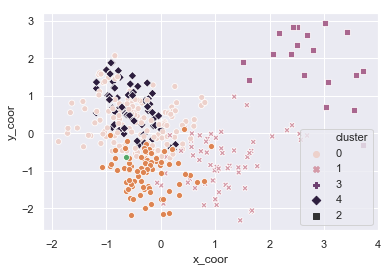

In [226]:

sns.scatterplot(x="x_coor", y="y_coor", hue="cluster",style="cluster",data=df_today)
sns.scatterplot(x="x_coor", y="y_coor",data=clust_p)
sns.scatterplot(x="x_coor", y="y_coor",data=f)

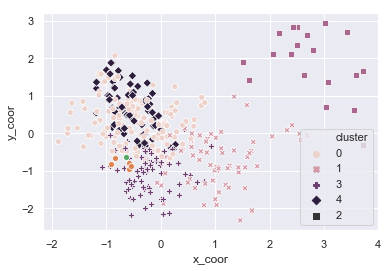

In [228]:

sns.scatterplot(x="x_coor", y="y_coor", hue="cluster",style="cluster",data=df_today)
sns.scatterplot(x="x_coor", y="y_coor",data=wrt_same_sort)
sns.scatterplot(x="x_coor", y="y_coor",data=f)


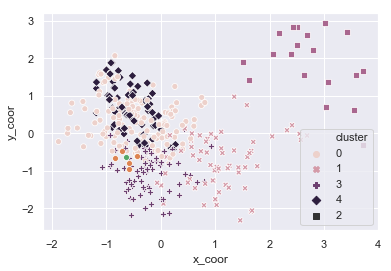

In [229]:
sns.scatterplot(x="x_coor", y="y_coor", hue="cluster",style="cluster",data=df_today)
sns.scatterplot(x="x_coor", y="y_coor",data=wrt_all_sort)
sns.scatterplot(x="x_coor", y="y_coor",data=f)

In [ ]:
f

In [ ]:
today = df.sort_values(by=['grant_date'])

In [ ]:
rank_sort = [i for i in range(1,384)]

In [ ]:
today['rank_date']=rank_sort

In [ ]:
today = today.drop('rank_date',axis=1)

In [ ]:
today

In [169]:
sns.scatterplot(x="x_coor", y="y_coor", hue="assignee",data=df_today)

/Applications/Ana/anaconda/lib/python3.6/site-packages/mpl_toolkits/mplot3d/art3d.py:726: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
/Applications/Ana/anaconda/lib/python3.6/site-packages/mpl_toolkits/mplot3d/art3d.py:728: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':
/Applications/Ana/anaconda/lib/python3.6/site-packages/mpl_toolkits/mplot3d/art3d.py:730: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir[0] == '-':


In [ ]:
df = df.drop(['distance0','distance1','distance2','distance3','distance4'],axis=1)

In [ ]:
df

In [ ]:
ssc = sorted_same_cluster.reset_index()

In [ ]:
ssc = ssc[:79]

# Technology evolution

In [ ]:
ssc = ssc.sort_values(by=['grant_date'])

In [ ]:
years = list(ssc['grant_date'])

In [ ]:
time = []
for i in years:
    time.append(i[:4])

In [ ]:
out = list(set(time))
out.sort()

In [ ]:
time_size = len(out)

In [ ]:
time_index=[i for i in range(1,time_size+1)]

In [ ]:
time_series = pd.DataFrame(
    {'years': out,
     'plane': time_index
    })

In [ ]:

time_series

In [ ]:
ssc['grant_year'] = time

In [ ]:
ssc

In [ ]:
rslt = pd.merge(ssc, time_series, left_on="grant_year", right_on="years")

In [ ]:
rslt

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
my_color=rslt['plane']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rslt['x_coor'], rslt['y_coor'], rslt['plane'], c=my_color, cmap="Set2_r", s=60)


In [ ]:
r_new = rslt.drop(['title','abstract','citation','cpc'],axis=1)

In [ ]:
r_new = r_new.drop(['years','terms','index'],axis=1)

In [ ]:
r_new.to_csv('tech_process.csv')

In [ ]:
r_new

In [ ]:
%matplotlib notebook
%matplotlib ipympl
from mpl_toolkits import mplot3d
plt.plot([0, 1, 2, 2]);

In [ ]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(df_today['x_coor'], df_today['y_coor'], df_today['z_coor'], color = 'white', cmap="Set2_r", s=60)
ax.scatter(f['x_coor'], f['y_coor'], f['z_coor'], color = 'red', cmap="Set2_r", s=60)
ax.scatter(wrt_all_sort['x_coor'], wrt_all_sort['y_coor'], wrt_all_sort['z_coor'], color = 'green', cmap="Set2_r", s=60)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(df_today['x_coor'], df_today['y_coor'], df_today['z_coor'], color = 'white', cmap="Set2_r", s=60)
ax.scatter(f['x_coor'], f['y_coor'], f['z_coor'], color = 'red', cmap="Set2_r", s=60)
ax.scatter(wrt_same_sort['x_coor'], wrt_same_sort['y_coor'], wrt_same_sort['z_coor'], color = 'green', cmap="Set2_r", s=60)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_today['x_coor'], df_today['y_coor'], df_today['z_coor'], color = 'white', cmap="Set2_r", s=60)
ax.scatter(f['x_coor'], f['y_coor'], f['z_coor'], color = 'red', cmap="Set2_r", s=60)
#ax.scatter(wrt_all_sort['x_coor'], wrt_all_sort['y_coor'], wrt_all_sort['z_coor'], color = 'green', cmap="Set2_r", s=60)

# Tech evolution for the full database

In [ ]:
oct_18 = df
oct_18 = oct_18.sort_values(by=['grant_date'])
all_years = list(oct_18['grant_date'])
all_time = []
for i in all_years:
    all_time.append(i[:4])
all_out = list(set(all_time))
all_out.sort()


In [ ]:
all_time_size = len(all_out)
all_time_index=[i for i in range(1,all_time_size+1)]
all_time_series = pd.DataFrame(
    {'years': all_out,
     'plane': all_time_index
    })
all_time_series

In [ ]:
oct_18['grant_year'] = all_time

In [ ]:
all_rslt = pd.merge(oct_18, all_time_series, left_on="grant_year", right_on="years")

In [ ]:
all_rslt

In [171]:
my_color=all_rslt['cluster']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(all_rslt['plane'], all_rslt['x_coor'], all_rslt['y_coor'], c=my_color, cmap="Set2_r", s=5)


/Applications/Ana/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


FigureCanvasNbAgg()

In [141]:
all_rslt.to_csv('timeseries.csv')

In [208]:
idea =  pd.read_csv('timeseries.csv', index_col = 0)

In [211]:
for i in range(0,5):
    for j in range(0,383):
        if idea.cluster[j] == i:
            idea.y_coor[j] = idea.y_coor[j] + 10*(i+1)

/Applications/Ana/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [219]:
my_color=idea['cluster']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(idea['plane'], idea['x_coor'], idea['y_coor'], c=my_color, cmap="Set2_r", s=2)


/Applications/Ana/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


FigureCanvasNbAgg()

In [200]:
temp = pd.DataFrame({'x': all_rslt['plane'], 'y': idea['y_coor'], 'z': all_rslt['x_coor'], 'h' : all_rslt['cluster']})


pal = sns.color_palette()
g = sns.FacetGrid(temp, row="x", hue="h", aspect=15, size=.5, palette=pal)
g.map(plt.scatter, 'y', 'z')
g.map(plt.axhline, y=0, lw=2, clip_on=False)
# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.00)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

plt.show()

/Applications/Ana/anaconda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Applications/Ana/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


FigureCanvasNbAgg()

In [214]:
test =  pd.read_csv('timeseries.csv', index_col = 0)

In [217]:
test['y_coor'].describe()

count    3.830000e+02
mean    -2.440751e-16
std      1.001308e+00
min     -2.321507e+00
25%     -6.725121e-01
50%     -1.575246e-02
75%      6.595068e-01
max      2.949852e+00
Name: y_coor, dtype: float64